In [1]:
!git clone https://github.com/karthajee/erav2master.git

fatal: destination path 'erav2master' already exists and is not an empty directory.


In [2]:
from erav2master.models import assignment13
from erav2master.utils import *
NUM_EPOCHS = 20

In [3]:
import lightning.pytorch as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import random_split, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import multiprocessing

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                        kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    


class LitResnet(L.LightningModule):

    def __init__(self, block, num_blocks, lr=0.01):

        super().__init__()
        
        # Hardcoding certain values     
        self.num_classes=10                           
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.learning_rate = lr

        # Model code        
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, self.num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)    
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)        
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=-1)
        
        # Add logging
        self.accuracy(y, preds)
        self.log('val_loss_step', loss, prog_bar=True)
        self.log('val_acc_step', self.accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=-1)
        
        # Add logging
        self.accuracy(y, preds)
        self.log('test_loss_step', loss, prog_bar=True)
        self.log('test_acc_step', self.accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.learning_rate, 
                total_steps=self.trainer.estimated_stepping_batches, div_factor=100, 
                final_div_factor=100, pct_start=0.3, anneal_strategy='linear', three_phase=False)
        return [optimizer], [scheduler]        

def ResNet18():
    return LitResnet(BasicBlock, [2, 2, 2, 2])

In [4]:
# Defining the DataModule
class CIFAR10Module(L.LightningDataModule):

    def __init__(self):
        super().__init__()
        self.data_dir = '.'
        self.means = (0.49139968, 0.48215827 ,0.44653124)
        self.stds = (0.24703233, 0.24348505, 0.26158768)
        train_transform_A = A.Compose(
            [
                A.Normalize(mean=self.means, std=self.stds, always_apply=True),
                A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                A.RandomCrop(width=32, height=32, always_apply=True),
                A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1,
                                min_height=16, min_width=16, fill_value=self.means, mask_fill_value=None),
                ToTensorV2()
            ]
        )
        test_transform_A = A.Compose(
            [
                A.Normalize(mean=self.means, std=self.stds, always_apply=True),
                ToTensorV2()
            ]
        )
        self.train_transform = lambda x : train_transform_A(image=np.array(x))['image']
        self.test_transform = lambda x : test_transform_A(image=np.array(x))['image']
        self.num_workers = get_avail_cpu_cores()
        self.batch_size = 512
        self.pin_memory = True        

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_dir, download=True, train=True)
        datasets.CIFAR10(root=self.data_dir, download=True, train=False)
    
    def setup(self, stage=None):

        if stage == 'fit' or stage is None:
            train_dset = datasets.CIFAR10(root=self.data_dir, train=True, transform=self.train_transform)
            self.cifar10_train, self.cifar10_val = random_split(train_dset, [0.8, 0.2])
        else:
            self.cifar10_test = datasets.CIFAR10(root=self.data_dir, train=False, transform=self.test_transform)
            
    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size,
                            shuffle=True, pin_memory=self.pin_memory, 
                            num_workers=self.num_workers, multiprocessing_context='fork')

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size,
                            shuffle=False, pin_memory=self.pin_memory, 
                            num_workers=self.num_workers, multiprocessing_context='fork')

    def test_dataloader(self):
        return DataLoader(self.cifar10_test, batch_size=self.batch_size,
                            shuffle=False, pin_memory=self.pin_memory, 
                            num_workers=self.num_workers, multiprocessing_context='fork')

In [4]:
model = ResNet18()
callbacks_l = [L.callbacks.LearningRateFinder(min_lr=1e-5, max_lr=10, num_training_steps=200)]
trainer = L.Trainer(callbacks=callbacks_l, accelerator='mps', max_epochs=NUM_EPOCHS, enable_progress_bar=True)

# tuner = L.pytorch.tuner.tuning.Tuner(trainer)
# lr_finder = tuner.lr_find(model, min_lr=1e-4, max_lr=10, num_training=20)
# # Results can be found in
# print(lr_finder.results)

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()
# print(new_lr)
# fig

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model)

Files already downloaded and verified
Files already downloaded and verified


Loading `train_dataloader` to estimate number of stepping batches.


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

LR finder stopped early after 184 steps due to diverging loss.
Learning rate set to 4.897788193684463e-05
Restoring states from the checkpoint path at /Users/karthajee/Documents/0_projects/ERAV2/ERAV2assignments/Session 13 - PyTorch Lightning, Fabrik, and Spaces/.lr_find_d1b732c9-1ca9-4eef-8265-b07af05ca2d5.ckpt
Restored all states from the checkpoint at /Users/karthajee/Documents/0_projects/ERAV2/ERAV2assignments/Session 13 - PyTorch Lightning, Fabrik, and Spaces/.lr_find_d1b732c9-1ca9-4eef-8265-b07af05ca2d5.ckpt

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | conv1    | Conv2d             | 1.7 K 
2 | bn1      | BatchNorm2d        | 128   
3 | layer1   | Sequential         | 147 K 
4 | layer2   | Sequential         | 525 K 
5 | layer3   | Sequential         | 2.1 M 
6 | layer4   | Sequential         | 8.4 M 
7 | linear   | Linear             | 5.1 K 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [6]:
trainer.test()

/Users/karthajee/opt/anaconda3/envs/erav2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/karthajee/Documents/0_projects/ERAV2/ERAV2assignments/Session 13 - PyTorch Lightning, Fabrik, and Spaces/lightning_logs/version_2/checkpoints/epoch=19-step=1554.ckpt
Loaded model weights from the checkpoint at /Users/karthajee/Documents/0_projects/ERAV2/ERAV2assignments/Session 13 - PyTorch Lightning, Fabrik, and Spaces/lightning_logs/version_2/checkpoints/epoch=19-step=1554.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_step         0.8281000256538391
     test_loss_step         0.5347569584846497
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_step': 0.5347569584846497, 'test_acc_step': 0.8281000256538391}]

# Load from Checkpoint

In [5]:
CKPT_DIR = "lightning_logs/version_2/checkpoints/epoch=19-step=1554.ckpt"
model_kwargs = dict(block=BasicBlock, num_blocks=[2, 2, 2, 2])
model = LitResnet.load_from_checkpoint(CKPT_DIR, **model_kwargs)

# Misclassified Images

In [6]:
cifar10_data_module = CIFAR10Module()
cifar10_data_module.setup()
cifar10_data_module.setup(stage='test')

/Users/karthajee/Documents/0_projects/ERAV2/ERAV2assignments/Session 13 - PyTorch Lightning, Fabrik, and Spaces/erav2master/utils.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


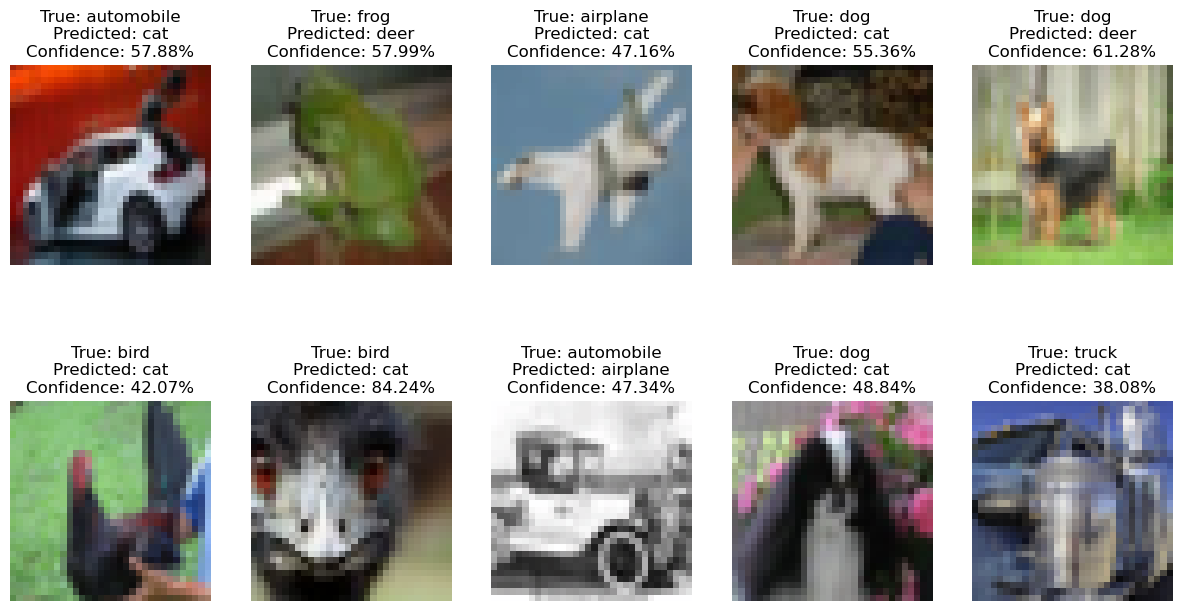

In [7]:
cifar10_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
misclassified = get_misclassified_images(model, cifar10_data_module.test_dataloader(), cifar10_classes, get_device())

In [8]:
len(misclassified['img_numpy'])

10

In [10]:
for i, img in enumerate(misclassified['img_numpy']):
    true = cifar10_classes[misclassified['y_true'][i]]
    pred = cifar10_classes[misclassified['y_pred'][i]]
    filename = f'{i}_true_{true}_pred_{pred}.png'
    export_cifar_image(img, filename=filename)

# Gradio App

Your spaces app has these features:
- ask the user whether he/she wants to see GradCAM images and how many, and from which layer, allow opacity change as well
- ask whether he/she wants to view misclassified images, and how many
- allow users to upload new images, as well as provide 10 example images
- ask how many top classes are to be shown (make sure the user cannot enter more than 10)

In [25]:
from PIL import Image
def resize_image_pil(image, new_width, new_height):

    # Convert to PIL image
    img = Image.fromarray(np.array(image))
    
    # Get original size
    width, height = img.size

    # Calculate scale
    width_scale = new_width / width
    height_scale = new_height / height 
    scale = min(width_scale, height_scale)

    # Resize
    resized = img.resize((int(width*scale), int(height*scale)), Image.NEAREST)
    
    # Crop to exact size
    resized = resized.crop((0, 0, new_width, new_height))

    return resized

def display_misclassified(num_images):
    img_folder = Path('misclassified')
    gallery_l = []
    i = 0    
    for img_path in img_folder.rglob('*.png'):
        if i >= int(num_images):
            break
        img = Image.open(img_path)
        img = resize_image_pil(img, 64, 64)
        a = str(img_path.stem).split('_')[1:]
        caption = f'True: {a[1]}\nPred: {a[3]}'
        gallery_l.append((img, caption))
        i += 1
    return gallery_l
display_misclassified(5)

iface = gr.Interface(
    display_misclassified,
    inputs=gr.Slider(0, 10, value=0, step=1, label="Number"),
    outputs=gr.Gallery(label='Misclassified Images', columns=4, height='auto')
)
iface.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In [17]:
import gradio as gr

In [ ]:
def inference():
    pass
    
inf_iface = gr.Interface(
    inference,
    inputs=[],
    outputs=[],
    examples=[]
)

In [ ]:
import gradio as gr
import torch
from torchvision import transforms
from PIL import Image

# Load your PyTorch model
model = torch.load('path_to_your_model.pth')
model.eval()

# Define necessary transformations for the input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def simulate_gradcam(image, layer, opacity):
    # This should generate a GradCAM overlay
    # For now, just return the original image
    return image

def show_misclassified_images(num_images):
    # This should return a list of misclassified images
    # For now, return a list of dummy images
    return [Image.new('RGB', (256, 256), (i * 50 % 255, 255, 128)) for i in range(num_images)]

# Prediction and processing function
def predict(image, top_k, gradcam_enabled, gradcam_layer, gradcam_opacity, show_misclassified, num_misclassified):
    image = transform(Image.fromarray(image.astype('uint8'))).unsqueeze(0)
    output = model(image)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top_probs, top_classes = probabilities.topk(top_k)

    results = {
        "Top Predictions": top_classes.flatten().tolist(),
        "Probabilities": top_probs.flatten().tolist(),
    }
    
    additional_outputs = {}
    
    if gradcam_enabled:
        gradcam_image = simulate_gradcam(image, gradcam_layer, gradcam_opacity)
        additional_outputs["GradCAM Output"] = gradcam_image
    
    if show_misclassified:
        misclassified_images = show_misclassified_images(num_misclassified)
        additional_outputs["Misclassified Images"] = misclassified_images
    
    return results, additional_outputs

# Gradio interface setup
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.inputs.Image(shape=(256, 256)),
        gr.inputs.Number(label="Number of top classes", default=5, maximum=10),
        gr.inputs.Checkbox(label="Enable GradCAM", elem_id="gradcam_checkbox"),
        gr.inputs.Dropdown(choices=['layer1', 'layer2', 'layer3'], label="Select GradCAM Layer", elem_id="gradcam_layer_dropdown"),
        gr.inputs.Slider(minimum=0, maximum=1, step=0.1, default=0.5, label="GradCAM Opacity", elem_id="gradcam_opacity_slider"),
        gr.inputs.Checkbox(label="Show Misclassified Images", elem_id="misclassified_checkbox"),
        gr.inputs.Number(label="Number of Misclassified Images", default=5, elem_id="misclassified_number"),
    ],
    outputs=[
        gr.outputs.Label(num_top_classes=10),
        gr.outputs.Image(label="GradCAM Output", id='gradcam_output', visible=False),
        gr.outputs.Gallery(label="Misclassified Images", id='misclassified_gallery', visible=False)
    ],
    examples=[
        # Paths to 10 example images
    ],
    js="""
    function(_, __, gradcam_enabled, ___, ____, misclassified_enabled, _____) {
        document.getElementById('gradcam_layer_dropdown').disabled = !gradcam_enabled;
        document.getElementById('gradcam_opacity_slider').disabled = !gradcam_enabled;
        document.getElementById('misclassified_number').disabled = !misclassified_enabled;
        return {
            'gradcam_output': gradcam_enabled,
            'misclassified_gallery': misclassified_enabled
        };        
    }
    """
)

iface.launch()